In [3]:
import datetime, os
import tensorflow as tf

from pathlib import Path
from matplotlib import pyplot as plt
from quickdraw import QuickDrawDataGroup, QuickDrawData

from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

from tensorflow.keras.callbacks import TensorBoard

In [18]:
image_size = (28, 28)

In [ ]:
image_size = (28, 28)

def generate_class_images(name, max_drawings, recognized):
    directory = Path("dataset/" + name)

    if not directory.exists():
        directory.mkdir(parents=True)

    images = QuickDrawDataGroup(name, max_drawings=max_drawings, recognized=recognized)
    for img in images.drawings:
        filename = directory.as_posix() + "/" + str(img.key_id) + ".png"
        img.get_image(stroke_width=3).resize(image_size).save(filename)

labels = ["eye", "square", "circle", "star"]

for label in labels:
    generate_class_images(label, max_drawings=2000, recognized=True)

loading eye drawings
load complete
loading square drawings
load complete
loading circle drawings
load complete
loading star drawings
load complete


In [11]:
batch_size = 32

train_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


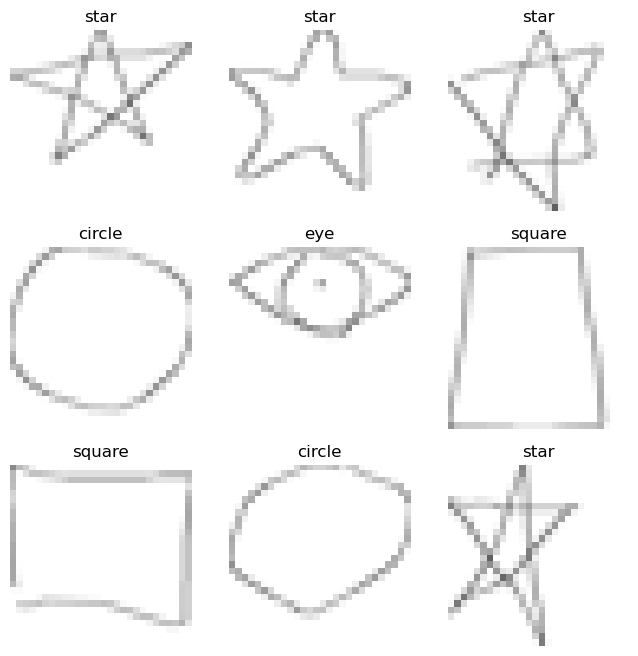

In [12]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        data = images[i].numpy().astype("uint8")
        plt.imshow(data, cmap='gray', vmin=0, vmax=255)
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [13]:
input_shape = (28, 28, 1)
n_classes = 4

model = Sequential([
    Rescaling(1. / 255, input_shape=input_shape),
    BatchNormalization(),

    Conv2D(6, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(8, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(10, kernel_size=(3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(700, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(500, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(400, activation='relu'),
    Dropout(0.2),

    Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 batch_normalization_4 (Bat  (None, 28, 28, 1)         4         
 chNormalization)                                                
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 6)         60        
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 8)         440       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 10)        730       
                                                                 
 batch_normalization_5 (Bat  (None, 28, 28, 10)        40        
 chNormalization)                                     

In [14]:
epochs = 40

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback],
)

# model.save('./models/model_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


Epoch 1/40
200/200 [==============================] - 17s 70ms/step - loss: 0.2332 - accuracy: 0.9258 - val_loss: 5.4953 - val_accuracy: 0.2400
Epoch 2/40
200/200 [==============================] - 11s 55ms/step - loss: 0.0988 - accuracy: 0.9691 - val_loss: 4.9289 - val_accuracy: 0.2494
Epoch 3/40
200/200 [==============================] - 15s 73ms/step - loss: 0.0739 - accuracy: 0.9770 - val_loss: 0.4454 - val_accuracy: 0.8600
Epoch 4/40
200/200 [==============================] - 14s 70ms/step - loss: 0.0563 - accuracy: 0.9816 - val_loss: 0.1199 - val_accuracy: 0.9650
Epoch 5/40
200/200 [==============================] - 14s 70ms/step - loss: 0.0428 - accuracy: 0.9872 - val_loss: 0.0886 - val_accuracy: 0.9737
Epoch 6/40
200/200 [==============================] - 14s 69ms/step - loss: 0.0277 - accuracy: 0.9919 - val_loss: 0.1558 - val_accuracy: 0.9575
Epoch 7/40
200/200 [==============================] - 15s 73ms/step - loss: 0.0452 - accuracy: 0.9859 - val_loss: 0.1554 - val_accuracy:

In [15]:
test_ds = image_dataset_from_directory(
    "dataset_test",
    image_size=image_size,
    batch_size=32,
    color_mode="grayscale"
)

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Found 800 files belonging to 4 classes.
25/25 [==============================] - 1s 25ms/step - loss: 0.0367 - accuracy: 0.9937
Test Accuracy: 99.37%


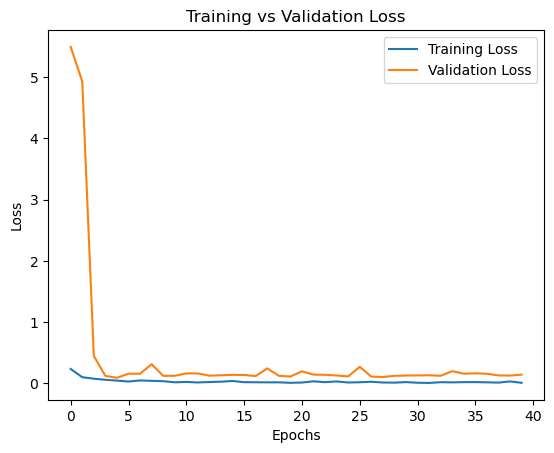

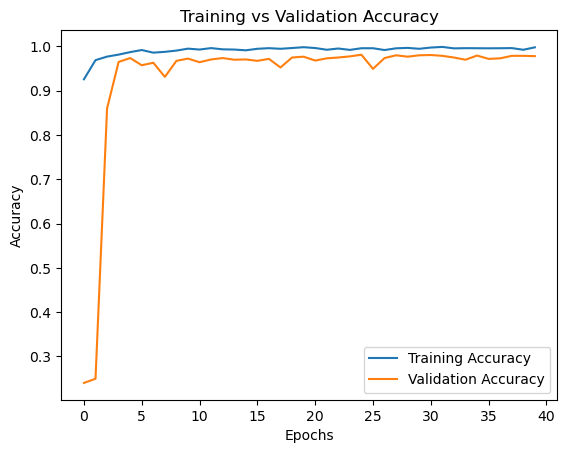

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = np.concatenate([np.argmax(y.numpy(), axis=1) if len(y.shape) > 1 else y.numpy() for x, y in val_ds], axis=0)

y_pred_prob = model.predict(val_ds)

y_pred = np.argmax(y_pred_prob, axis=1)

print(f"Shape y_true: {y_true.shape}, Shape y_pred: {y_pred.shape}")

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=1) 
recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)

# Cetak hasil evaluasi
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


50/50 [==============================] - 1s 16ms/step
Shape y_true: (1600,), Shape y_pred: (1600,)
Accuracy: 0.2744
Precision: 0.2745
Recall: 0.2744
F1 Score: 0.2744


50/50 [==============================] - 1s 16ms/step


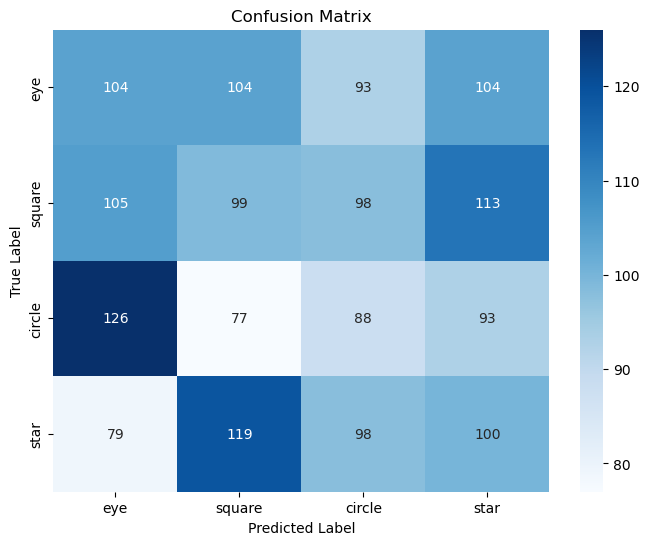

In [23]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ["eye", "square", "circle", "star"]

y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)  

y_true = np.concatenate([y for x, y in val_ds], axis=0)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [25]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Fungsi untuk memuat gambar dan melakukan prediksi
def predict_image(model, image_path):
    img = image.load_img(image_path, color_mode="grayscale", target_size=(28, 28))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    img_array = img_array / 255.0 

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    
    return predicted_class, predictions

saved_model_path = './models/model_20250218-194525' 

loaded_model = tf.keras.models.load_model(saved_model_path)

image_path = 'dataset/star/4504975667363840.png' 

predicted_class, predictions = predict_image(loaded_model, image_path)

print("Predicted Class:", predicted_class)
print("Predictions:", predictions)


1/1 [==============================] - 0s 247ms/step
Predicted Class: 1
Predictions: [[0.000000e+00 1.000000e+00 0.000000e+00 8.150005e-15]]


In [31]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image_tflite(tflite_model, image_path):
    interpreter = tf.lite.Interpreter(model_path=tflite_model)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Load and preprocess the image
    img = image.load_img(image_path, color_mode="grayscale", target_size=(28, 28))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output_data)

    return predicted_class, output_data

tflite_model_path = 'model.tflite' 

image_path = 'dataset/star/4504975667363840.png' 

predicted_class_tflite, predictions_tflite = predict_image_tflite(tflite_model_path, image_path)

print("Predicted Class (TFLite):", predicted_class_tflite)
print("Predictions (TFLite):", predictions_tflite)


Predicted Class (TFLite): 3
Predictions (TFLite): [[0.0000e+00 0.0000e+00 6.6799e-19 1.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]


In [51]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("models/model_20250218-194525") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)